In [1]:
%load_ext autoreload

%autoreload 2

In [178]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from validation.metrics import OME, MSE
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from MODELS.ViscNN import create_ViscNN, create_ViscNN_concat,create_ViscNN_comb, create_ViscNN_phys
from validation.tests import viscNN_LC, crossval_NN, Mw_extrapolation, Mw_test, evaluate_model
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR
from data_tools.dim_red import fp_PCA
pd.options.mode.chained_assignment = None  # default='warn'

In [393]:
data = pd.read_excel('Data/full_data_2021-11-08.xlsx')

In [394]:
extrap, PL_data, extrap_samps = Mw_extrapolation(data.copy(), 10)
#data = pd.concat([data, extrap], ignore_index = True).reset_index(drop = True)

Found Zero Shear Samples
Found LOBF for samples
Generating sample...0
Generating sample...1
Generating sample...2
Generating sample...3
Generating sample...4
Generating sample...5
Generating sample...6
Generating sample...7
Generating sample...8
Generating sample...9


In [395]:
do_pca = True
if do_pca:
    data, fp_cols, pca = fp_PCA(data)
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
else:
    fp_cols = []
    for c in data.columns:
        if isinstance(c, str):
            if 'afp' in c or 'bfp' in c or 'mfp' in c or 'efp' in c:
                fp_cols.append(c)
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']

Explained variance (ratio): [0.34511932 0.1813519  0.10194128 0.06710149 0.05863391 0.03994611
 0.03556155 0.02749411 0.0209672  0.0158005 ]
Total variance in 10 components = 0.8939173686355604


In [396]:
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

data['ZERO_SHEAR'] = 1
data['SHEAR'] = 0
data['log_Shear_Rate'] = 0
for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'log_Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data.loc[i, 'SHEAR'] = 1
        data.loc[i, 'ZERO_SHEAR'] = 0
        #data = data.drop([i])

In [552]:
#cols.remove('Shear_Rate')
filtered_data = data.loc[:, cols + ['Polymer', 'SHEAR', 'ZERO_SHEAR', 'log_Shear_Rate']].dropna(subset = ['Mw', 'Shear_Rate'])
#X_tot = np.array(filtered_data.filter(fp_cols + ['SHEAR', 'ZERO_SHEAR']))
X_tot = np.array(filtered_data.filter(fp_cols))
tot_samples = X_tot.shape[0]
Y_tot = np.array(filtered_data.loc[:,'Melt_Viscosity']).reshape((tot_samples,1))

In [553]:
logMw = np.array(filtered_data['Mw']).reshape((tot_samples,1))
log_shear = np.array(filtered_data['log_Shear_Rate']).reshape((tot_samples,1))
shear = np.array(filtered_data['Shear_Rate']).reshape((tot_samples,1))
Temp = np.array(filtered_data['Temperature']).reshape((tot_samples,1))
scaler = MinMaxScaler(copy = False)
scaler.fit(X_tot).transform(X_tot);
#y_scaler = MinMaxScaler(copy = False)
#y_scaler.fit(Y_tot).transform(Y_tot);
S_scaler = MinMaxScaler().fit(log_shear)
log_shear = S_scaler.transform(log_shear)
T_scaler = MinMaxScaler().fit(Temp)
Temp = T_scaler.transform(Temp);
M_scaler = MinMaxScaler().fit(logMw)
logMw = M_scaler.transform(logMw);


In [554]:
XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test, train_ind, test_ind, shear_train, shear_test = train_test_split(X_tot, Y_tot, logMw, log_shear, Temp, range(tot_samples), shear, test_size= 0.10)

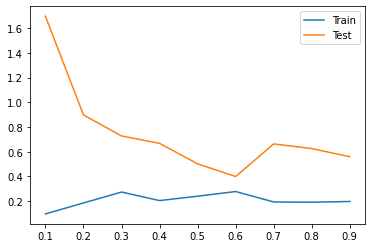

In [68]:
n, train, test = viscNN_LC(create_ViscNN_concat, X_tot, Y_tot, logMw, log_shear, Temp)
plt.plot(n, train)
plt.plot(n, test)
plt.legend(['Train','Test'])

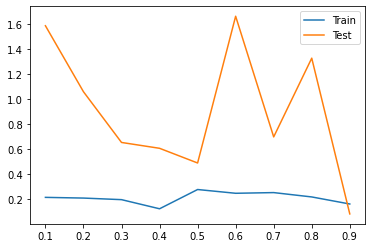

In [65]:
n, train, test = viscNN_LC(create_ViscNN_comb, X_tot, Y_tot, logMw, log_shear, Temp, S_scaler= S_scaler, T_scaler=T_scaler,M_scaler= M_scaler)
plt.plot(n, train)
plt.plot(n, test)
plt.legend(['Train','Test'])

In [472]:
model = crossval_NN(create_ViscNN_comb, XX, yy, M, S, T, S_scaler, T_scaler, M_scaler, verbose = 1, random_state = 10)

MSE: 0.493, RMSE: 0.702
MSE: 0.357, RMSE: 0.597
MSE: 0.490, RMSE: 0.700
MSE: 0.607, RMSE: 0.779
MSE: 13.688, RMSE: 3.700
CV MSE error:3.126923108100891


Test MSE:0.37468448281288147
Test OME:0.51590455


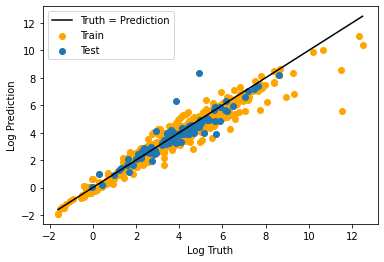

In [473]:
#plt.scatter(yy, model.predict([XX, M, S, T]), c = 'orange')
#plt.scatter(y_test,  model.predict([X_test, M_test, S_test, T_test]))
#plt.scatter(yy, model.predict([XX, M_scaler.inverse_transform(M), S_scaler.inverse_transform(S), T_scaler.inverse_transform(T)]), c = 'orange')
#plt.scatter(y_test, model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]))
test_pred =  model.predict([X_test, M_test, S_test, T_test,M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)])
train_pred = model.predict([XX, M, S, T, M_scaler.inverse_transform(M), S_scaler.inverse_transform(S), T_scaler.inverse_transform(T)])
plt.scatter(yy, train_pred, c = 'orange')
plt.scatter(y_test, test_pred)

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
#rmse = metrics.RMSE(mean, yy)
#mape = metrics.MAPE(mean, yy)
#print("Test MSE:" + str(model.evaluate([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
#print("Test OME:" + str(OME(model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]), y_test).numpy()))
print("Test MSE:" + str(model.evaluate([X_test, M_test, S_test, T_test,M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
print("Test OME:" + str(OME(test_pred, y_test).numpy()))

In [ ]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
test_df[test_df['BAD_PRED'] == True]

In [555]:
model_phys = crossval_NN(create_ViscNN_phys, XX, yy, M, shear_train, T, S_scaler= S_scaler, M_scaler = M_scaler, verbose = 1, random_state = 10)

MSE: 0.517, RMSE: 0.719
MSE: 0.641, RMSE: 0.800
MSE: 0.720, RMSE: 0.848
MSE: 0.637, RMSE: 0.798
MSE: 0.826, RMSE: 0.909
CV MSE error:0.6680560946464539


Test OME:1.0612925


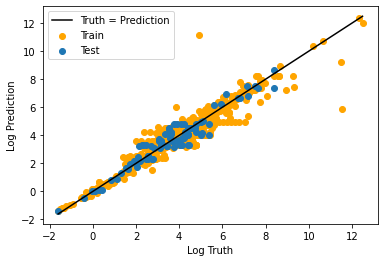

In [556]:
test_pred =  model_phys.predict([X_test, M_test, T_test, np.power(10, M_scaler.inverse_transform(M_test)), shear_test])
train_pred = model_phys.predict([XX, M, T, np.power(10, M_scaler.inverse_transform(M)), shear_train])
plt.scatter(yy, train_pred, c = 'orange')
plt.scatter(y_test, test_pred)

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
#rmse = metrics.RMSE(mean, yy)
#mape = metrics.MAPE(mean, yy)
#print("Test MSE:" + str(model.evaluate([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
#print("Test OME:" + str(OME(model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]), y_test).numpy()))
#print("Test MSE:" + str(model.evaluate([X_test, M_test, S_test, T_test,M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
print("Test OME:" + str(OME(test_pred, y_test).numpy()))

In [374]:
model_NP = crossval_NN(create_ViscNN_concat, XX, yy, M, S, T, verbose = 1, random_state = 10)

MSE: 0.669, RMSE: 0.818
MSE: 0.374, RMSE: 0.611
MSE: 0.208, RMSE: 0.456
MSE: 3.449, RMSE: 1.857
MSE: 0.748, RMSE: 0.865
CV MSE error:1.0893918037414552


Test MSE:0.2313043773174286
Test OME:2.5101328


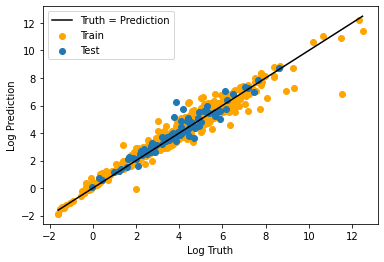

In [428]:
test_pred = model_NP.predict([X_test, M_test, S_test, T_test])
train_pred =  model_NP.predict([XX, M, S, T])
plt.scatter(yy, train_pred, c = 'orange')
plt.scatter(y_test, test_pred)
#plt.scatter(yy, model.predict([XX, M_scaler.inverse_transform(M), S_scaler.inverse_transform(S), T_scaler.inverse_transform(T)]), c = 'orange')
#plt.scatter(y_test, model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]))
#plt.scatter(yy, model.predict([XX, M, S, T, M_scaler.inverse_transform(M), S_scaler.inverse_transform(S), T_scaler.inverse_transform(T)]), c = 'orange')
#plt.scatter(y_test,  model.predict([X_test, M_test, S_test, T_test,M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]))

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
#rmse = metrics.RMSE(mean, yy)
#mape = metrics.MAPE(mean, yy)
#print("Test MSE:" + str(model.evaluate([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)],y_test , verbose=0)))
#print("Test OME:" + str(OME(model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]), y_test).numpy()))
print("Test MSE:" + str(model_NP.evaluate([X_test, M_test, S_test, T_test],y_test , verbose=0)))
print("Test OME:" + str(OME(test_pred, y_test).numpy()))

In [27]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
test_df[test_df['BAD_PRED'] == True]

1.2638481761709977


,0,1,2,3,4,5,6,7,8,9,Mw,Temperature,Shear_Rate,Melt_Viscosity,Polymer,SHEAR,ZERO_SHEAR,Y_pred,Error,BAD_PRED
278,-1.006943,0.243833,0.225600,0.300323,-0.429627,-0.497729,0.353552,0.275641,-0.105901,-0.048789,4.301030,139.183673,0.0,2.397849,Poly(ethyl-n-butylsilylene),0,1,1.112468,1.285382,True
277,-1.006943,0.243833,0.225600,0.300323,-0.429627,-0.497729,0.353552,0.275641,-0.105901,-0.048789,4.301030,119.591837,0.0,2.741935,Poly(ethyl-n-butylsilylene),0,1,1.182985,1.558951,True
312,0.146021,-1.349768,-0.386517,0.497850,-0.128732,-0.309967,-0.050217,0.383234,0.034220,-0.203388,4.602060,232.000000,0.0,12.487138,"poly(2,6-dimethylphenol)",0,1,2.126910,10.360228,True
147,2.607707,0.607634,-0.342056,-0.118286,-0.285236,-0.087235,0.308054,0.090309,0.215158,0.000892,3.959041,120.000000,0.0,11.559714,polystyrene,0,1,4.676861,6.882853,True


In [154]:
gpr_model = train_GPR(XX, yy, M, S, T)

Test MSE:0.3167766945008578
Test OME:tf.Tensor(0.2134495961423849, shape=(), dtype=float64)


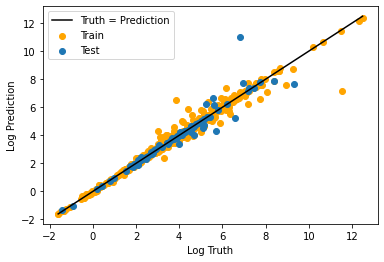

In [159]:
X_ = np.concatenate((X_test, M_test, S_test, T_test), axis = 1)
X_train = np.concatenate((XX, M, S, T), axis = 1)
test_pred, var = gpr_model.predict_y(X_)
## generate 10 samples from posterior

print("Test MSE:" + str(MSE(test_pred, y_test)))
print("Test OME:" + str(OME(test_pred, y_test)))

# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
train_pred, var_train = gpr_model.predict_y(X_train)
plt.scatter(yy, train_pred, c = 'orange')
plt.scatter(y_test, test_pred)
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.legend(['Truth = Prediction', 'Train','Test'])
plt.show()

In [156]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
test_df[test_df['BAD_PRED'] == True]

NameError: name 'evaluate_model' is not defined

In [ ]:
tuner = kt.Hyperband(create_ViscNN_concat, objective='val_loss',
                     max_epochs=10,
                     factor=3, project_name = 'create_ViscNN_concat2')

tuner.search([XX, M, S, T], yy,
             validation_data= ([X_test, M_test, S_test, T_test], y_test),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

In [452]:
#PL_data.head(10)
extrap_tests = Mw_test(PL_data.copy(), samps = [0,1,2,3,4,5,6,7,8,9,10,11,12])

  SAMPLE_ID      Polymer   SMILES  Temperature          Mcr    Log_K1  \
2         6  Linear HDPE  [*]C[*]        150.0  3656.398809 -3.904875   

     Log_K2     Alpha  afp_C4_C4_C4  afp_C4_C4_F1  ...  bfp_378  bfp_429  \
2 -13.40241  3.665561      0.333333           0.0  ...      0.0      0.0   

   afp_C3_C3_N3  afp_C3_N3_C3  bfp_46  bfp_47  bfp_55  bfp_79  bfp_210  \
2           0.0           0.0     0.0     0.0     0.0     0.0      0.0   

   Shear_Rate  
2           0  

[1 rows x 206 columns]


In [465]:
samp_num = 0
XX_ex, OH, M_ex,S_ex,T_ex,y_ex = extrap_tests[samp_num]['data_in']
Mw_ex = extrap_samps[samp_num][0]
log_visc_ex = extrap_samps[samp_num][1]
XX_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
M_ex = M_scaler.transform(M_ex)
S_ex = S_scaler.transform(S_ex)
T_ex = T_scaler.transform(T_ex)

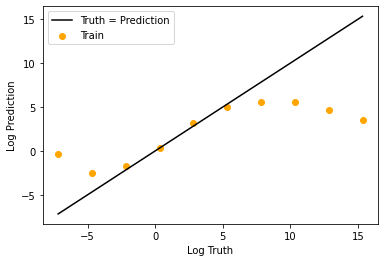

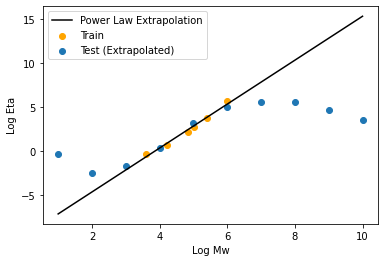

In [469]:
test_pred = model.predict([XX_ex, M_ex, S_ex, T_ex,M_scaler.inverse_transform(M_ex), S_scaler.inverse_transform(S_ex), T_scaler.inverse_transform(T_ex)])
plt.scatter(y_ex, test_pred, c = 'orange')

plt.plot(np.linspace((min(y_ex)[0]), (max(y_ex)[0]), num = 2),np.linspace((min(y_ex)[0]), (max(y_ex)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])

plt.figure()
plt.xlabel('Log Mw')
plt.ylabel('Log Eta')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
plt.plot(M_scaler.inverse_transform(M_ex), y_ex, c = 'k')
plt.legend(['Power Law Extrapolation','Train','Test (Extrapolated)'])

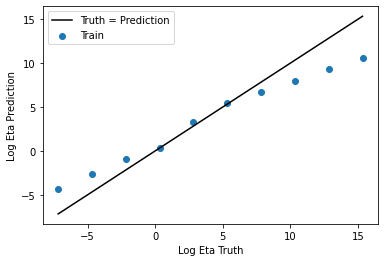

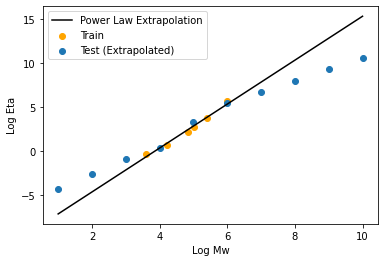

In [470]:
test_pred = model_NP.predict([XX_ex, M_ex, S_ex, T_ex])
plt.scatter(y_ex, test_pred)
#plt.scatter(yy, model.predict([XX, M_scaler.inverse_transform(M), S_scaler.inverse_transform(S), T_scaler.inverse_transform(T)]), c = 'orange')
#plt.scatter(y_test, model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]))
#plt.scatter(yy, model.predict([XX, M, S, T, M_scaler.inverse_transform(M), S_scaler.inverse_transform(S), T_scaler.inverse_transform(T)]), c = 'orange')
#plt.scatter(y_test,  model.predict([X_test, M_test, S_test, T_test,M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]))

plt.plot(np.linspace((min(y_ex)[0]), (max(y_ex)[0]), num = 2),np.linspace((min(y_ex)[0]), (max(y_ex)[0]), num = 2),'k-')
plt.ylabel('Log Eta Prediction')
plt.xlabel('Log Eta Truth')
plt.legend(['Truth = Prediction','Train','Test'])

plt.figure()
plt.xlabel('Log Mw')
plt.ylabel('Log Eta')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
plt.plot(M_scaler.inverse_transform(M_ex), y_ex, c = 'k')
plt.legend(['Power Law Extrapolation','Train','Test (Extrapolated)'])

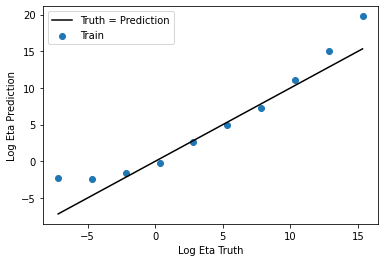

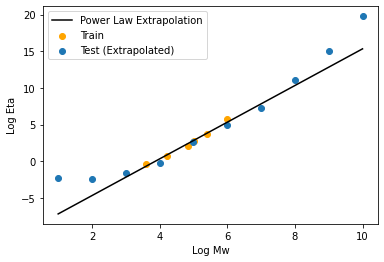

In [528]:
test_pred = model_phys.predict([XX_ex, M_ex, T_ex, np.power(10, M_scaler.inverse_transform(M_ex)), S_ex])
plt.scatter(y_ex, test_pred)
#plt.scatter(yy, model.predict([XX, M_scaler.inverse_transform(M), S_scaler.inverse_transform(S), T_scaler.inverse_transform(T)]), c = 'orange')
#plt.scatter(y_test, model.predict([X_test, M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]))
#plt.scatter(yy, model.predict([XX, M, S, T, M_scaler.inverse_transform(M), S_scaler.inverse_transform(S), T_scaler.inverse_transform(T)]), c = 'orange')
#plt.scatter(y_test,  model.predict([X_test, M_test, S_test, T_test,M_scaler.inverse_transform(M_test), S_scaler.inverse_transform(S_test), T_scaler.inverse_transform(T_test)]))

plt.plot(np.linspace((min(y_ex)[0]), (max(y_ex)[0]), num = 2),np.linspace((min(y_ex)[0]), (max(y_ex)[0]), num = 2),'k-')
plt.ylabel('Log Eta Prediction')
plt.xlabel('Log Eta Truth')
plt.legend(['Truth = Prediction','Train','Test'])

plt.figure()
plt.xlabel('Log Mw')
plt.ylabel('Log Eta')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
plt.plot(M_scaler.inverse_transform(M_ex), y_ex, c = 'k')
plt.legend(['Power Law Extrapolation','Train','Test (Extrapolated)'])

In [411]:
PL_data

,SAMPLE_ID,Polymer,SMILES,Temperature,Mcr,Log_K1,Log_K2,Alpha,afp_C4_C4_C4,afp_C4_C4_F1,...,bfp_378,bfp_429,afp_C3_C3_N3,afp_C3_N3_C3,bfp_46,bfp_47,bfp_55,bfp_79,bfp_210,Shear_Rate
0,0,poly(prop-1-ene),[*]CC([*])C,200.0,NaN,0,-9.667328,2.499047,0.444444,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,polyisobutylene,[*]CC([*])(C)C,25.0,NaN,0,-9.948751,3.357126,0.583333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,6,Linear HDPE,[*]C[*],150.0,3656.398809,-3.904875,-13.402410,3.665561,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,7,polyisobutylene,[*]CC([*])(C)C,150.0,NaN,0,-13.936685,3.565737,0.583333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,8,polyisobutylene,[*]CC([*])(C)C,175.0,NaN,0,-14.003194,3.507579,0.583333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,9,polyisobutylene,[*]CC([*])(C)C,200.0,NaN,0,-15.621807,3.740412,0.583333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,14,polystyrene,[*]CC([*])c1ccccc1,217.0,NaN,0,-8.944816,2.480751,0.125000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,15,polystyrene,[*]CC([*])c1ccccc1,190.0,NaN,0,-9.253014,2.617630,0.125000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,16,polystyrene,[*]CC([*])c1ccccc1,160.0,NaN,0,-8.345240,2.664743,0.125000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,17,polystyrene,[*]CC([*])c1ccccc1,140.0,NaN,0,-14.696159,4.598960,0.125000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [557]:
#data[ and data['Polymer'] == 'poly(methyl methacrylate)']
shear_test_ex = data[data['Temperature'] == 100][data['Polymer'] == 'poly(epsilon-caprolactone)'][data['Mw'] == np.log10(35500)]
shear_test_S = np.array(shear_test_ex['Shear_Rate']).reshape((-1,1))
shear_test_S_ex = np.array([1,2,3,4]).reshape((-1,1))
shear_test_y = np.array(shear_test_ex['Melt_Viscosity']).reshape((-1,1))

C:\Users\ayush\AppData\Local\Temp/ipykernel_20248/1811823349.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shear_test_ex = data[data['Temperature'] == 100][data['Polymer'] == 'poly(epsilon-caprolactone)'][data['Mw'] == np.log10(35500)]


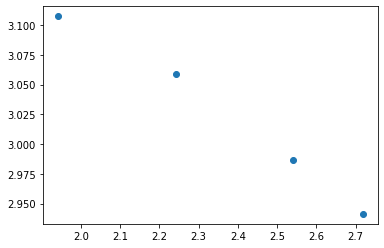

In [558]:
plt.scatter(np.log10(shear_test_S), shear_test_y)
shear_test_XX = scaler.transform(np.array(shear_test_ex[fp_cols]))
shear_test_T = T_scaler.transform(np.array(shear_test_ex['Temperature']).reshape(-1, 1))
shear_test_M = M_scaler.transform(np.array(shear_test_ex['Mw']).reshape(-1, 1))

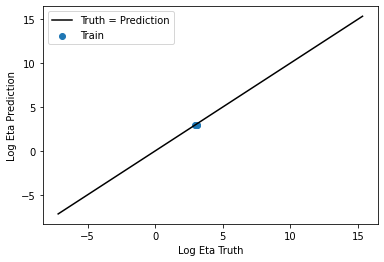

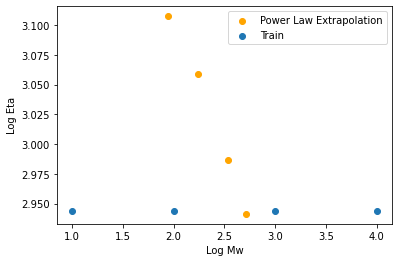

In [559]:
test_pred = model_phys.predict([shear_test_XX, shear_test_M, shear_test_T, np.power(10, M_scaler.inverse_transform(shear_test_M)), shear_test_S])
plt.scatter(shear_test_y, test_pred)

plt.plot(np.linspace((min(y_ex)[0]), (max(y_ex)[0]), num = 2),np.linspace((min(y_ex)[0]), (max(y_ex)[0]), num = 2),'k-')
plt.ylabel('Log Eta Prediction')
plt.xlabel('Log Eta Truth')
plt.legend(['Truth = Prediction','Train','Test'])

plt.figure()
plt.xlabel('Log Mw')
plt.ylabel('Log Eta')
plt.scatter(np.log10(shear_test_S), shear_test_y, c = 'orange')
plt.scatter(shear_test_S_ex, test_pred)
#plt.plot(M_scaler.inverse_transform(M_ex), y_ex, c = 'k')
plt.legend(['Power Law Extrapolation','Train','Test (Extrapolated)'])

array([[60000.],
       [60000.],
       [60000.],
       [60000.],
       [60000.],
       [60000.],
       [60000.],
       [60000.]])